# Evaluación de LLMs con Arquitecturas RAG - Código Abierto vs Comerciales

## Librerias e Imports

In [ ]:
## Instalación de librerías requeridas

!pip install -q markdown
!pip install -q langchain
!pip install -q openai
!pip install -q ragas
!pip install -q datasets
!pip install -q "huggingface_hub[inference]"
!pip install -q llama-index-embeddings-huggingface
!pip install -q llama-index-embeddings-instructor
!pip install -q sentence-transformers
!pip install -q llama-index
!pip install -q text_generation
!pip install -q llama-index-llms-vllm
!pip install -q llama-index-llms-huggingface
!pip install -q llama-index-embeddings-azure-openai
!pip install -q llama-index-llms-azure-openai
!pip install -q llama-index-llms-openai-like
!pip install -q llama-index-embeddings-langchain
!pip install -q llama-index-llms-langchain

In [34]:
## Importación de librerías
import os
import logging
import sys
from typing import List, Optional
import pandas as pd
import nest_asyncio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### AzureOpenAI Libs
from openai import AzureOpenAI
from google.colab import drive

### AzureOpenAI Langchain
from langchain_openai.chat_models import AzureChatOpenAI
from langchain_openai.embeddings import AzureOpenAIEmbeddings
from ragas import evaluate

### Datasets from HuggingFaceDatasets
from datasets import load_dataset

## Llama Index
from llama_index.core import VectorStoreIndex,SimpleDirectoryReader,ServiceContext,PromptTemplate, Document
from llama_index.llms.huggingface import HuggingFaceLLM
from llama_index.llms.huggingface import HuggingFaceInferenceAPI
from llama_index.llms.azure_openai import AzureOpenAI
from llama_index.embeddings.azure_openai import AzureOpenAIEmbedding
from llama_index.core import VectorStoreIndex, SimpleDirectoryReader
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.llms.vllm import VllmServer
from llama_index.core.llms import ChatMessage

## Dataset y Preprocesado

## Amnesty QA dataset

Este conjunto de datos contiene las siguientes columnas

* question: list[str] - Estas son las preguntas sobre las que se evaluará la pipeline RAG.

* context: list[list[str]] - Los contextos que fueron pasados al LLM para responder la pregunta.

* ground_truth: list[str] -  La respuesta verdadera a las preguntas.


In [4]:
amnesty_qa = load_dataset("explodinggradients/amnesty_qa", "english_v2")
amnesty_qa

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1461: FutureWarning: The repository for explodinggradients/amnesty_qa contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/explodinggradients/amnesty_qa
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major relea

/usr/local/lib/python3.10/dist-packages/huggingface_hub/repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")


Generating eval split: 0 examples [00:00, ? examples/s]

DatasetDict({
    eval: Dataset({
        features: ['question', 'ground_truth', 'answer', 'contexts'],
        num_rows: 20
    })
})

## Preprocesado

In [14]:
### Cargar los datos de la libreria AmnestyQA y Preprocesar

## Preguntas
test_questions = amnesty_qa['eval']['question'][:20]
print("Questions:")
for question in test_questions:
    print(question)

## Respuestas
test_answers = [[answer] for answer in amnesty_qa['eval']['answer'][:20]]
print("\nAnswers:")
for answer in test_answers:
    print(answer)

## Contexto
doc_contexts = [[context] for context in amnesty_qa['eval']['contexts'][:20]]
print("\nContexts:")
for i, context in enumerate(doc_contexts):
    # Display only the first 300 characters of each context for brevity
    preview = context[0][:300] + '...' if len(context[0]) > 300 else context[0]
    print(f"Context {i+1}: {preview}")

# Escribirlo en disco para poder cargar el contexto para el LLM + RAG
with open('context.txt', 'w', encoding='utf-8') as file:
    for context in doc_contexts:
        if isinstance(context[0], list):  # Check if the context is a list of strings
            context_string = ' '.join(context[0])
        else:
            context_string = context[0]
        file.write(context_string + '\n')


Questions:
What are the global implications of the USA Supreme Court ruling on abortion?
Which companies are the main contributors to GHG emissions and their role in global warming according to the Carbon Majors database?
Which private companies in the Americas are the largest GHG emitters according to the Carbon Majors database?
What action did Amnesty International urge its supporters to take in response to the killing of the Ogoni 9?
What are the recommendations made by Amnesty International to the Special Rapporteur on Human Rights Defenders?
Who are the target audience of the two books created by Amnesty International on child rights?
Which right guarantees access to comprehensive information about past human rights violations, including the identities of the perpetrators and the fate of the victims, as well as the circumstances surrounding the violations?
Who has the right to be fully informed about human rights violations, including the identities of the perpetrators and the fat

In [15]:
## Cargar los documentos con el contexto de las preguntas
reader = SimpleDirectoryReader("./",num_files_limit=30)
documents = reader.load_data()

print(documents)

[Document(id_='cb3fa427-8470-47d0-854f-556b65f78db5', embedding=None, metadata={'file_path': '/content/context.txt', 'file_name': 'context.txt', 'file_type': 'text/plain', 'file_size': 16200, 'creation_date': '2024-04-15', 'last_modified_date': '2024-04-15'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={}, text='- In 2022, the USA Supreme Court handed down a decision ruling that overturned 50 years of jurisprudence recognizing a constitutional right to abortion.\n- This decision has had a massive impact: one in three women and girls of reproductive age now live in states where abortion access is either totally or near-totally inaccessible.\n- The states with the most restrictive abortion laws have the weakest maternal health support, higher maternal death rate

## Arquitectura basada en RAG

In [10]:
## Funciones para construir la arquitectura basada en RAG

nest_asyncio.apply()

def build_query_engine(llm):
    vector_index = VectorStoreIndex.from_documents(
        documents, llm=azure_model,
        embed_model=azure_embeddings,
    )

    query_engine = vector_index.as_query_engine(similarity_top_k=2)
    return query_engine

# Function to evaluate as Llama index does not support async evaluation for HFInference API
def generate_responses(query_engine, test_questions, test_answers):
  responses = [query_engine.query(q) for q in test_questions]

  answers = []
  contexts = []
  for r in responses:
    answers.append(r.response)
    contexts.append([c.node.get_content() for c in r.source_nodes])
  dataset_dict = {
        "question": test_questions,
        "answer": answers,
        "contexts": contexts,
  }
  if test_answers is not None:
      # Join each list of ground_truth answers into a single string, if necessary
      ground_truth = [' '.join(ans) if isinstance(ans, list) else ans for ans in test_answers]
      dataset_dict["ground_truth"] = ground_truth
  ds = Dataset.from_dict(dataset_dict)
  return ds

## RAG Metrics

* **Fidelidad (Faithfulness)** - Mide la consistencia factual de la respuesta con el contexto basado en la pregunta.
* **Precisión del Contexto (Context_precision)** - Mide cuán relevante es el contexto recuperado para la pregunta, reflejando la calidad del pipeline de recuperación.

* **Relevancia de la Respuesta (Answer_relevancy)** - Mide cuán relevante es la respuesta para la pregunta.

* **Exhaustividad del Contexto (Context_recall)** -  Mide la capacidad del recuperador para obtener toda la información necesaria requerida para responder la pregunta.

In [16]:
## Métricas RAG

from datasets import Dataset
from ragas import evaluate
from ragas.metrics import (
        context_precision,
        faithfulness,
        answer_correctness,
        answer_relevancy,
        context_recall,
)

metrics = [
        context_precision,
        faithfulness,
        answer_correctness,
        answer_relevancy,
        context_recall,
]

* **Retriever**: Ofrece precisión del contexto y cobertura del contexto, que miden el rendimiento de tu sistema de recuperación.

* **Generator (LLM)**: Proporciona fidelidad, que mide las alucinaciones, y relevancia de la respuesta, que mide cuán relevantes son las respuestas a la pregunta.

# Evalución de arquitecturas basadas RAG con LLMs de Código Abierto y Comerciales

# Con AzureOpenAI 3.5

In [6]:
## Azure OpenAI Config Data
azure_configs = {
    "base_url": "https://aroaoidemo.openai.azure.com/",
    "model_deployment": "gpt-35-turbo",
    "model_name": "gpt-35-turbo",
    "embedding_deployment": "text-embedding-ada-002",
    "embedding_name": "text-embedding-ada-002",
}

In [7]:
## Cargar las liberias de AzureChatOpenAI
azure_model = AzureChatOpenAI(
    openai_api_version="2024-02-01",
    azure_endpoint=azure_configs["base_url"],
    azure_deployment=azure_configs["model_deployment"],
    model=azure_configs["model_name"],
    validate_base_url=False,
)

azure_embeddings = AzureOpenAIEmbeddings(
    openai_api_version="2024-02-01",
    azure_endpoint=azure_configs["base_url"],
    azure_deployment=azure_configs["embedding_deployment"],
    model=azure_configs["embedding_name"],
)

In [17]:
#from ragas.llama_index import evaluate # This is for LlamaIndex but doesn't work with AzureOpenAI
# https://docs.ragas.io/en/stable/howtos/integrations/llamaindex.html
# https://github.com/explodinggradients/ragas/issues/669

from ragas import evaluate

result_azure_openai = evaluate(
    amnesty_qa["eval"],
    metrics=metrics,
    llm=azure_model,
    embeddings=azure_embeddings)

result_azure_openai

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

{'context_precision': 1.0000, 'faithfulness': 0.7356, 'answer_correctness': 0.5920, 'answer_relevancy': 0.9718, 'context_recall': 0.9383}

In [18]:
result_azure_openai_df = result_azure_openai.to_pandas()
result_azure_openai_df.head()

,question,ground_truth,answer,contexts,context_precision,faithfulness,answer_correctness,answer_relevancy,context_recall
0,What are the global implications of the USA Su...,The global implications of the USA Supreme Cou...,The global implications of the USA Supreme Cou...,"[- In 2022, the USA Supreme Court handed down ...",1.0,1.000000,0.406478,0.988008,1.000000
1,Which companies are the main contributors to G...,"According to the Carbon Majors database, the m...","According to the Carbon Majors database, the m...","[- Fossil fuel companies, whether state or pri...",1.0,0.454545,0.350825,0.963235,0.666667
2,Which private companies in the Americas are th...,The largest private companies in the Americas ...,"According to the Carbon Majors database, the l...",[The private companies responsible for the mos...,1.0,0.833333,0.592782,0.986323,1.000000
3,What action did Amnesty International urge its...,Amnesty International urged its supporters to ...,Amnesty International urged its supporters to ...,[Amnesty International called on its vast netw...,1.0,1.000000,0.831708,0.985097,1.000000
4,What are the recommendations made by Amnesty I...,The recommendations made by Amnesty Internatio...,Amnesty International made several recommendat...,[Amnesty International recommends that the Spe...,1.0,0.090909,0.864417,0.993765,1.000000


# Con Llama2

In [72]:
## Usar Llama2 LLM que utiliza vLLM para el despliegue
def completion_to_prompt(prompt):
  return f"[INST] {prompt} [/INST] "

llama2_llm = VllmServer(
    api_url=api_url,
    max_new_tokens=500,
    temperature=0,
)

In [73]:
## Test Llama Index con liberias de Azure OpenAI LlamaIndex
from llama_index.core import Settings

Settings.llm = azure_model
Settings.embed_model = azure_embeddings

def build_query_engine_llama2(llm):
    vector_index = VectorStoreIndex.from_documents(
        documents,
    )

    query_engine = vector_index.as_query_engine(similarity_top_k=2)
    return query_engine

query = "What is most interesting about this essay?"
#query_engine = index.as_query_engine()
query_engine = build_query_engine_llama2(llama2_llm)
answer = query_engine.query(query)

print(answer.get_formatted_sources())
print("query was:", query)
print("answer was:", answer)

> Source (Doc id: 228cc387-e081-4c4b-81cc-5860ee6c9a82): - In 2022, the USA Supreme Court handed down a decision ruling that overturned 50 years of jurisp...

> Source (Doc id: 6e925fd5-9958-4774-a25c-29e9bcf1fb0f): The objectives of the two books are to build children’s and young people’s understanding of their...
query was: What is most interesting about this essay?
answer was: I'm sorry, but I cannot answer the query as the given context information does not provide any clue or statement about what is most interesting about this essay. It only contains various statements related to topics such as abortion, fossil fuel emissions, human rights violations, and civil society organizations.


In [21]:
## Evaluar Llama2 con RAG usando RAGAS
query_engine1 = build_query_engine_llama2(llama2_llm)
result_ds = generate_responses(query_engine1, test_questions, test_answers)
result_llama2 = evaluate(
    result_ds,
    metrics=metrics,
    llm=azure_model,
    embeddings=azure_embeddings
)

result_llama2

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

{'context_precision': 0.6500, 'faithfulness': 1.0000, 'answer_correctness': 0.5040, 'answer_relevancy': 0.8829, 'context_recall': 0.7458}

In [32]:
## Transform result to pandas to better comprehension
result_llama2_df = result_llama2.to_pandas()
result_llama2_df.head()

,question,answer,contexts,ground_truth,context_precision,faithfulness,answer_correctness,answer_relevancy,context_recall
0,What are the global implications of the USA Su...,The ruling by the USA Supreme Court that overt...,"[- In 2022, the USA Supreme Court handed down ...",The global implications of the USA Supreme Cou...,1.0,1.0,0.457287,0.878779,1.0
1,Which companies are the main contributors to G...,"According to the Carbon Majors database, 100 e...","[Companies, including social media companies, ...","According to the Carbon Majors database, the m...",0.5,1.0,0.662684,0.945794,1.0
2,Which private companies in the Americas are th...,"According to the Carbon Majors database, the p...","[Companies, including social media companies, ...","According to the Carbon Majors database, the l...",0.5,1.0,0.468679,0.976739,1.0
3,What action did Amnesty International urge its...,The provided context information does not cont...,"[- In 2022, the USA Supreme Court handed down ...",Amnesty International urged its supporters to ...,0.0,NaN,0.213918,0.000000,1.0
4,What are the recommendations made by Amnesty I...,Social media companies involved in facilitatin...,"[- At the same time, it prohibits censorship.\...",Amnesty International made several recommendat...,1.0,1.0,0.545316,0.938441,0.0


## Con Mixtral

In [70]:
## Evaluate Mixtral with RAG using RAGAS
mixtral_llm = HuggingFaceInferenceAPI(
    model_name="mistralai/Mixtral-8x7B-Instruct-v0.1",
    token=token
)

In [27]:
query_engine1 = build_query_engine(mixtral_llm)
result_ds = generate_responses(query_engine1, test_questions, test_answers)
result_mixtral = evaluate(
    result_ds,
    metrics=metrics,
    llm=azure_model,
    embeddings=azure_embeddings
)

result_mixtral

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

{'context_precision': 0.6500, 'faithfulness': 0.9912, 'answer_correctness': 0.5214, 'answer_relevancy': 0.9224, 'context_recall': 0.7271}

In [28]:
result_mixtral_df = result_mixtral.to_pandas()
result_mixtral_df.head()

,question,answer,contexts,ground_truth,context_precision,faithfulness,answer_correctness,answer_relevancy,context_recall
0,What are the global implications of the USA Su...,The ruling by the USA Supreme Court on abortio...,"[- In 2022, the USA Supreme Court handed down ...",The global implications of the USA Supreme Cou...,1.0,1.0,0.507076,0.936924,1.0
1,Which companies are the main contributors to G...,"According to the Carbon Majors database, the 1...","[Companies, including social media companies, ...","According to the Carbon Majors database, the m...",0.5,1.0,0.505324,0.869887,1.0
2,Which private companies in the Americas are th...,"According to the context information, the priv...","[Companies, including social media companies, ...","According to the Carbon Majors database, the l...",0.5,1.0,0.581517,0.957958,1.0
3,What action did Amnesty International urge its...,There is no provided information about Amnesty...,"[- In 2022, the USA Supreme Court handed down ...",Amnesty International urged its supporters to ...,0.0,NaN,0.219419,0.976038,1.0
4,What are the recommendations made by Amnesty I...,Social media companies involved in facilitatin...,"[- At the same time, it prohibits censorship.\...",Amnesty International made several recommendat...,1.0,1.0,0.544277,0.891081,0.0


# Comparación Métricas entre Modelos de Código Abierto y Comerciales

In [58]:
import pandas as pd

results_df = pd.DataFrame({
    'Metric': ['Precisión del Contexto', 'Fidelidad', 'Corrección de la Respuesta', 'Relevancia de la Respuesta', 'Exhaustividad del Contexto'],
    'Mixtral-8x7B': pd.Series(result_mixtral),
    'Llama-2-7b': pd.Series(result_llama2),
    'OpenAI-GPT-3.5': pd.Series(result_azure_openai)
})

results_df.set_index('Metric', inplace=True)
print(results_df)


                            Mixtral-8x7B  Llama-2-7b  OpenAI-GPT-3.5
Metric                                                              
Precisión del Contexto          0.650000    0.650000        1.000000
Fidelidad                       0.991228    1.000000        0.735606
Corrección de la Respuesta      0.521377    0.504039        0.591971
Relevancia de la Respuesta      0.922351    0.882883        0.971777
Exhaustividad del Contexto      0.727083    0.745833        0.938333


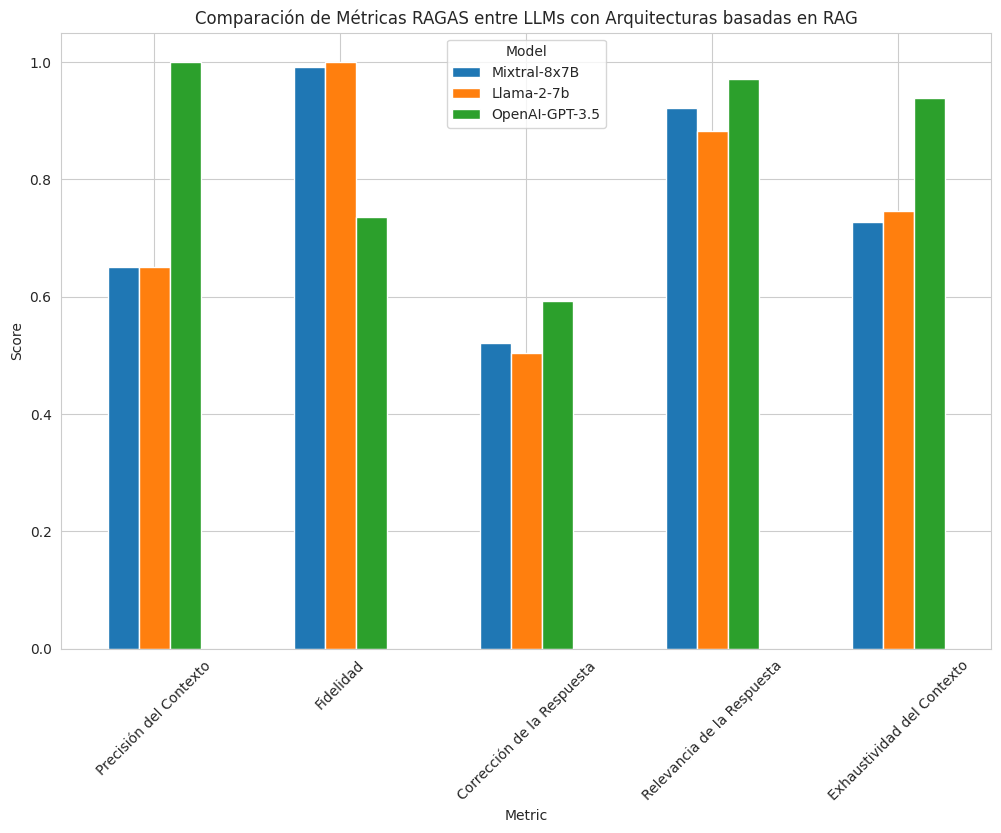

In [59]:
import matplotlib.pyplot as plt

results_df.plot(kind='bar', figsize=(12, 8))
plt.title('Comparación de Métricas RAGAS entre LLMs con Arquitecturas basadas en RAG')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title='Model')
plt.show()

## Comparación de Modelos con Gráficas de Dispersión

In [62]:
import plotly.graph_objects as go

data_mixtral = {
    'context_precision': result_mixtral['context_precision'],
    'faithfulness': result_mixtral['faithfulness'],
    'answer_relevancy': result_mixtral['answer_relevancy'],
    'context_recall': result_mixtral['context_recall'],
    'answer_correctness': result_mixtral['answer_correctness'],
}

data_openai = {
    'context_precision': result_azure_openai['context_precision'],
    'faithfulness': result_azure_openai['faithfulness'],
    'answer_relevancy': result_azure_openai['answer_relevancy'],
    'context_recall': result_azure_openai['context_recall'],
    'answer_correctness': result_azure_openai['answer_correctness'],
}

data_llama2 = {
    'context_precision': result_llama2['context_precision'],
    'faithfulness': result_llama2['faithfulness'],
    'answer_relevancy': result_llama2['answer_relevancy'],
    'context_recall': result_llama2['context_recall'],
    'answer_correctness': result_llama2['answer_correctness'],
}

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
    r=list(data_mixtral.values()),
    theta=list(data_mixtral.keys()),
    fill='toself',
    name='Mixtral-8x7B-Instruct-v0.1'
))

fig.add_trace(go.Scatterpolar(
    r=list(data_openai.values()),
    theta=list(data_openai.keys()),
    fill='toself',
    name='OpenAI-GPT-3.5-Turbo'
))

fig.add_trace(go.Scatterpolar(
    r=list(data_llama2.values()),
    theta=list(data_llama2.keys()),
    fill='toself',
    name='Llama-2-7b-chat-hf'
))

fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 1]
        )),
    showlegend=True,
    title='Generación Aumentada por Recuperación (RAG) - Comparación de Modelos',
    width=800,
)

fig.show()


# Compare Answer Relevancy and Answer Scores

In [66]:
def analysis(mixtral_df, llama2_df, openai_df):
    sns.set_style("whitegrid")
    fig, axs = plt.subplots(1, len(mixtral_df.columns), figsize=(12, 5))  # Assuming all DataFrames have the same columns

    # Iterate over the columns and plot the data for each model on each axis
    for i, col in enumerate(mixtral_df.columns):
        sns.kdeplot(data=mixtral_df[col].values, ax=axs[i], fill=True, label="Mixtral-8x7B")
        sns.kdeplot(data=llama2_df[col].values, ax=axs[i], fill=True, label="Llama-2-7b")
        sns.kdeplot(data=openai_df[col].values, ax=axs[i], fill=True, label="OpenAI 3.5")

        axs[i].set_title(f'Distribución de las puntuaciones de {col}')
        axs[i].legend()

    plt.tight_layout()
    plt.show()

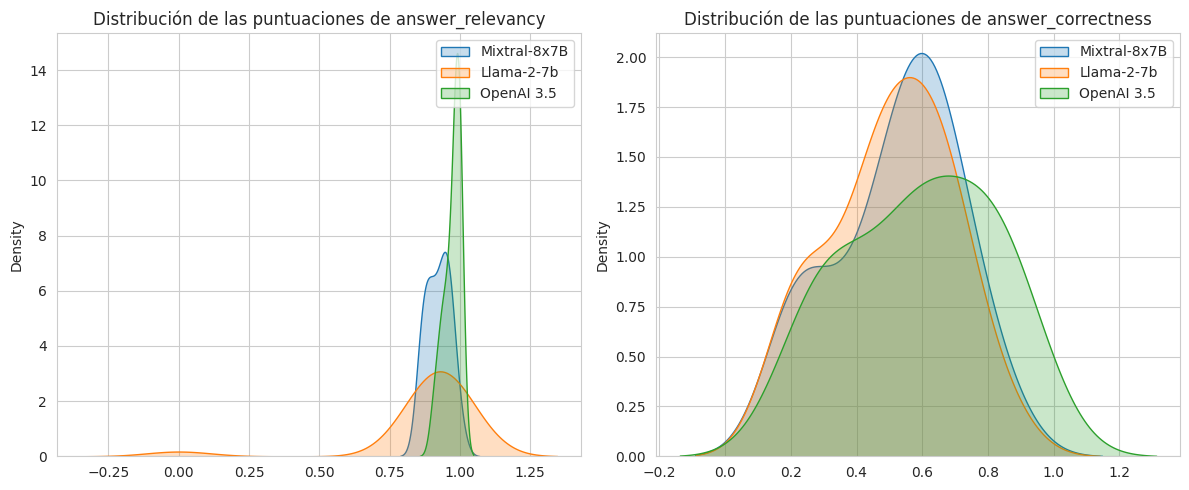

In [67]:
analysis(
    result_mixtral_df[['answer_relevancy', 'answer_correctness']],
    result_llama2_df[['answer_relevancy', 'answer_correctness']],
    result_azure_openai_df[['answer_relevancy', 'answer_correctness']]
)